In [1]:
'''将训练集中的后30个做验证集，前81个做训练集，然后探究模型自身在训练集和验证集上的效果'''
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt   #jupyter要matplotlib.pyplot
import numpy as np
import pandas as pd
from pandas import DataFrame
device = 'cuda:0' if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
filepath = "train.csv"
train_data = pd.read_csv(filepath) #抛弃了验证集后30条序列的训练集
dev_data = pd.read_csv("dev.csv")

In [3]:
'''将train.csv and test.csv 中的数据转化为np.array，按照原格式111*735一行一行的存入数组中'''
def loaddata(data, rows, lines):#将每一行的各列的数据放入train_data_row中
    data_rows=[]
    for row in range(0,rows):
        data_row=[]
        for line in range(0,lines):
            data_row.append(data[str(line)][row]) #将每一行的各列的数据放入train_data_row中
        data_rows.append(data_row)
    return np.array(data_rows)

In [4]:
def normalizationdata(data):  #归一化
    range = np.max(data) - np.min(data)
    return (data - np.min(data)) / range

In [5]:
'''将训练数据和测试数据的每一行都装入train_data_rows'''
train_data_rows = loaddata(train_data, 81, 735)
dev_data_rows = loaddata(dev_data, 30, 735)

In [6]:
'''将数据归一化处理'''
train_data_rows_nor = normalizationdata(train_data_rows)
dev_data_rows_nor = normalizationdata(dev_data_rows)
#test_data_rows_nor[0]

In [7]:
'''输入为归一化的数据data_nor,输入长度num_row和数据总行数rows。根据不同的输入步长num_row，将分割出来的数据放入到data_rows中
data_rows=[训练数据(num_row)，训练数据的验证(长度为56)]
输入的数据为归一化处理过后的训练集，以及输入步长'''
def input_size(data_nor, num_row, rows):#输出为定长56，而输入长度可以改变，为num_rows
    train_data_rows = []
    test_data_rows = []

    for row in range(0,rows):
        train_data_row = []
        test_data_row = []
        for line in range(0,735):
            count=line
            data_row_train = []
            data_row_test = []

            if line + num_row + 56 - 1 == 735: #如果输入输出步长加上起始位置超过最大列下标，则推出本行循环
                break

            while True:
                if count  < line+num_row:
                    data_row_train.append(data_nor[row][count]) #将每一行的各列的数据放入data_row_train中
                    count += 1

                elif count >= line+num_row and count<line+num_row+56:#如果count大于等于输入步长且小于输入加输出步长，则输入到data_row_test中
                    data_row_test.append(data_nor[row][count])
                    count += 1
                
                elif count == line+num_row+56: #如果输入输出步长加上起始位置超过最大列下标，则推出本行循环
                    break

            train_data_row.append(data_row_train)
            test_data_row.append(data_row_test)

        train_data_rows.append(train_data_row)
        test_data_rows.append(test_data_row)

    return np.array(train_data_rows), np.array(test_data_rows)
    

In [8]:
'''得到不同输入步长的训练集合,training_data_input_x的维度为(行数（111），每一行划分成了多少个训练样本/测试样本集合，输入步长)'''
training_data_input_56, train_data_output_56 = input_size(train_data_rows_nor, 56, 81)
dev_data_input_56, dev_data_output_56 = input_size(dev_data_rows_nor, 56, 30)

training_data_input_112, train_data_output_112 = input_size(train_data_rows_nor, 112, 81)
dev_data_input_112, dev_data_output_112 = input_size(dev_data_rows_nor, 112, 30)

training_data_input_679, train_data_output_679 = input_size(train_data_rows_nor, 679, 81)
dev_data_input_679, dev_data_output_679 = input_size(dev_data_rows_nor, 679, 30)

In [9]:
'''pytorch搭建mlp模型'''
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=679):    #输入步长默认为679
        super(NeuralNetwork,self).__init__()
        self.input_size = input_size
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size,128),
            nn.ReLU(),
            nn.Linear(128,32),
            nn.ReLU(),
            nn.Linear(32,56)
        )
    #forward和init函数要对齐，否则报错NotImplementedError
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
'''将数据转化为tensor'''
train_input_56, train_output_56 = torch.tensor(training_data_input_56), torch.tensor(train_data_output_56)
train_input_112, train_output_112 = torch.tensor(training_data_input_112), torch.tensor(train_data_output_112)
train_input_679, train_output_679 = torch.tensor(training_data_input_679), torch.tensor(train_data_output_679)

'''将数据转化为tensor'''
dev_input_56, dev_output_56 = torch.tensor(dev_data_input_56), torch.tensor(dev_data_output_56)
dev_input_112, dev_output_112 = torch.tensor(dev_data_input_112), torch.tensor(dev_data_output_112)
dev_input_679, dev_output_679 = torch.tensor(dev_data_input_679), torch.tensor(dev_data_output_679)



In [11]:
'''初始化模型，定义损失函数和优化方法'''
model_56 = NeuralNetwork(56).to(device)
model_112 = NeuralNetwork(112).to(device)
model_679 = NeuralNetwork(679).to(device)

loss_MSE = nn.MSELoss()#定义损失函数MSE
loss_MAE = nn.L1Loss()#定义损失函数MAE

optimizer_56 = torch.optim.SGD(model_56.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()
optimizer_112 = torch.optim.SGD(model_112.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()
optimizer_679 = torch.optim.SGD(model_679.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

In [12]:
'''计算训练集和验证集各行的最大值和最小值'''
train_max = np.max(train_data_rows, axis = 1).reshape(train_data_rows.shape[0],1)  #axis = 1 找每行最大的 ,reshape到规范的(行数，1)才能进行repeat
train_min = np.min(train_data_rows, axis = 1).reshape(train_data_rows.shape[0],1) 

#train_max_repeat =  np.repeat(train_max, train_output_56.shape[1], axis=1)#将training_max扩展为(81行, 每行有多少个输入输出对，1)
#training_max = torch.tensor(train_max_repeat).view(train_output_56.shape[0],train_output_56.shape[1], 1)  #将train_max_repeat转化为tonsor形式,并且形状要加上去掉的最后1维保持能与train_output一起运算
#print(training_max.shape)

dev_max = np.max(dev_data_rows, axis = 1).reshape(dev_data_rows.shape[0],1)
dev_min = np.min(dev_data_rows, axis = 1).reshape(dev_data_rows.shape[0],1)

In [13]:
'''sMAPE精确度指标'''
def sMAPE(pred, y):
    n = pred.shape[0] * pred.shape[1]  #各个维度相乘，计算一共有多少个元素   （81*56个元素）
    sum = abs(pred-y)/(abs(pred+y)/2)
    acc = torch.sum(sum)/n #将所有元素相加
    return acc*100
    
'''将归一化的数据恢复成原本的数据'''
def reverse_normalizationdata(data,max,min):
    range = max - min
    return torch.mul(data, range)+min

In [14]:
'''计算训练集本身的sMAPE指标
输入训练集作为标签的那一部分数据，预测的prediction，'''
def cal_sMAPE_train(train_output, prediction, train_max, train_min, input_size):

    training_max = torch.tensor(train_max).view(train_max.shape[0],1)
    training_min = torch.tensor(train_min).view(train_min.shape[0],1)
    
    #train_max_repeat =  np.repeat(train_max, train_output.shape[1], axis=1) #将training_max扩展为(81行, 每行有多少个输入输出对，1)
    #training_max = torch.tensor(train_max_repeat).view(train_output.shape[0],1,1)  #将train_max_repeat转化为tonsor形式,并且形状要加上去掉的最后1维保持能与train_output匹配维度一起运算

    #train_min_repeat =  np.repeat(train_min, train_output.shape[1], axis=1) #将training_max扩展为(81行, 每行有多少个输入输出对，1)
    #training_min = torch.tensor(train_min_repeat).view(train_output.shape[0],1,1)  #将train_max_repeat转化为tonsor形式,并且形状要加上去掉的最后1维保持能与train_output匹配维度一起运算

    pred = reverse_normalizationdata(prediction, training_max, training_min)  
    y = reverse_normalizationdata(train_output, training_max, training_min)

    acc = sMAPE(pred, y)

    print("输入步长为"+str(input_size)+"的训练集/验证集上的sMAPE指标："+str(acc.item())) #item可以只保留数字

    return acc

In [15]:
'''训练函数,输入为train_input_xx和train_output_xx,输入步长等'''
def train(X_datas, y_datas, input_size, model, loss_def, optimizer, epochs):
    rows = X_datas.shape[0]
    nums = X_datas.shape[1]
    model.train() #启用batch normalization和drop out,如果有

    losses = []
    iterations = []

    for epoch in range(epochs):
        for row in range(rows):  
            num = 0
            while num<nums:
                X = X_datas[row][num]
                y = y_datas[row][num]
                X, y = X.to(device), y.to(device)

                num += input_size+56  #不对重复的数据进行迭代训练

                pred = model(X)#预测值
                loss = loss_def(pred, y)#损失计算

                optimizer.zero_grad()#后向传播
                loss.backward()
                optimizer.step()

                loss = loss.item()

        if epoch%50 == 0:
            print("the loss of epoch "+ str(epoch) + " is: " + str(loss))
            losses.append(loss)
            iterations.append(epoch)

    prediction = model(X_datas.to(device))


    plt.figure()
    plt.title("loss of epochs per 50————————the input size: "+str(input_size)+"    the loss is: " + str(loss_def))
    plt.xlabel("epoch per 50")
    plt.ylabel("loss")
    plt.plot(iterations,losses)
    
    plt.show()

    return prediction.to('cpu')

the loss of epoch 0 is: 0.021858777850866318
the loss of epoch 50 is: 0.005560289602726698
the loss of epoch 100 is: 0.00774857634678483
the loss of epoch 150 is: 0.00832087267190218
the loss of epoch 200 is: 0.008123626001179218
the loss of epoch 250 is: 0.007789138238877058
the loss of epoch 300 is: 0.007429839111864567
the loss of epoch 350 is: 0.007064324337989092
the loss of epoch 400 is: 0.006704321596771479
the loss of epoch 450 is: 0.006350675132125616


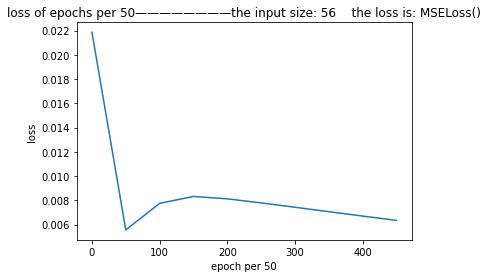

输入步长为56的训练集/验证集上的sMAPE指标：27.160154363206363


In [152]:
'''输入步长56，利用训练集训练模型，并计算训练集自身的sMAPE值
由于如果所有的包含重叠的数据进行预测，运算很大，并且sMAPE也会很大，即如果对1，2，3，4，8，6，2进行1个输入1个输出的预测，就要对1，2；2，3；3，4；；4，8；等进行预测，这样多计算的sMAPE就会使得其不稳定
因此我们还是简单化，使用训练数据的最后一个输入输出对来进行sMAPE的计算

MSE_SGD_输入步长56'''
model_56_mse_sgd = NeuralNetwork(56).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_56 = torch.optim.SGD(model_56_mse_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

input_length = 56 

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(train_input_56.to(torch.float32), train_output_56.to(torch.float32), 56, model_56_mse_sgd, loss_MSE, optimizer_56, 500)

acc_56 = cal_sMAPE_train(train_output_56[:,[train_output_56.shape[1]-1],:].squeeze(), prediction[:,[train_output_56.shape[1]-1],:].squeeze(), train_max, train_min, 56)
#train_output_56[:,[train_output_56.shape[1]-1],:].squeeze()表示取(81,所有输出对,输出步长)中的(81,最后一个输出，输出步长),然后将维度为1的中间那维去掉，与prediction做sMAPE

the loss of epoch 0 is: 0.1153334230184555
the loss of epoch 50 is: 0.06891921907663345
the loss of epoch 100 is: 0.05974763259291649
the loss of epoch 150 is: 0.05129086226224899
the loss of epoch 200 is: 0.04425344243645668
the loss of epoch 250 is: 0.04184404015541077
the loss of epoch 300 is: 0.04110906645655632
the loss of epoch 350 is: 0.04118698462843895
the loss of epoch 400 is: 0.04125823453068733
the loss of epoch 450 is: 0.041314560920000076


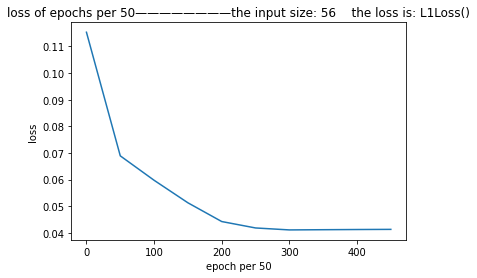

输入步长为56的训练集/验证集上的sMAPE指标：22.570370001901647


In [17]:
'''输入步长56——SGD——MAE'''
model_56_mae_sgd = NeuralNetwork(56).to(device)
loss_MAE = nn.L1Loss()#定义损失函数MSE
optimizer_56 = torch.optim.SGD(model_56_mae_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

input_length = 56 

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(train_input_56.to(torch.float32), train_output_56.to(torch.float32), 56, model_56_mae_sgd, loss_MAE, optimizer_56, 500)

acc_56 = cal_sMAPE_train(train_output_56[:,[train_output_56.shape[1]-1],:].squeeze(), prediction[:,[train_output_56.shape[1]-1],:].squeeze(), train_max, train_min, 56)
#train_output_56[:,[train_output_56.shape[1]-1],:].squeeze()表示取(81,所有输出对,输出步长)中的(81,最后一个输出，输出步长),然后将维度为1的中间那维去掉，与prediction做sMAPE

the loss of epoch 0 is: 0.004228181205689907
the loss of epoch 50 is: 0.0020758006721735
the loss of epoch 100 is: 0.0014416348421946168
the loss of epoch 150 is: 0.0016750784125179052
the loss of epoch 200 is: 0.0013098493218421936
the loss of epoch 250 is: 0.001709215110167861


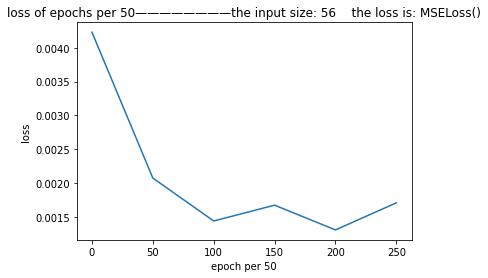

输入步长为56的训练集/验证集上的sMAPE指标：30.627265555959166


In [19]:
'''输入步长56_ADAM_MSE'''
model_56_mse_adam = NeuralNetwork(56).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_56 = torch.optim.Adam(model_56_mse_adam.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)

input_length = 56 

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(train_input_56.to(torch.float32), train_output_56.to(torch.float32), 56, model_56_mse_adam, loss_MSE, optimizer_56, 300)

acc_56 = cal_sMAPE_train(train_output_56[:,[train_output_56.shape[1]-1],:].squeeze(), prediction[:,[train_output_56.shape[1]-1],:].squeeze(), train_max, train_min, 56)
#train_output_56[:,[train_output_56.shape[1]-1],:].squeeze()表示取(81,所有输出对,输出步长)中的(81,最后一个输出，输出步长),然后将维度为1的中间那维去掉，与prediction做sMAPE

the loss of epoch 0 is: 0.027382034808397293
the loss of epoch 50 is: 0.005741129629313946
the loss of epoch 100 is: 0.00572794396430254
the loss of epoch 150 is: 0.006094526033848524
the loss of epoch 200 is: 0.006012862082570791
the loss of epoch 250 is: 0.005808950401842594
the loss of epoch 300 is: 0.005571126937866211
the loss of epoch 350 is: 0.0053287991322577
the loss of epoch 400 is: 0.0050975545309484005
the loss of epoch 450 is: 0.004876494407653809


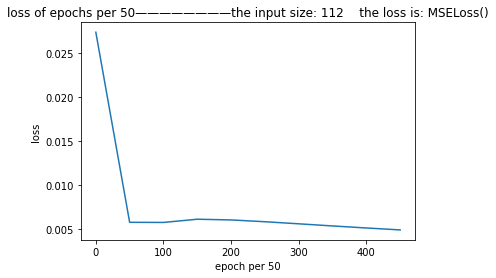

输入步长为112的训练集/验证集上的sMAPE指标：27.61446733430762


In [153]:
'''输入步长112_SGD_MSE
利用训练集训练模型，并计算训练集自身的sMAPE值'''
model_112_mse_sgd = NeuralNetwork(112).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_112 = torch.optim.SGD(model_112_mse_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(train_input_112.to(torch.float32), train_output_112.to(torch.float32), 112, model_112_mse_sgd, loss_MSE, optimizer_112, 500)

acc_112 = cal_sMAPE_train(train_output_112[:,[train_output_112.shape[1]-1],:].squeeze(), prediction[:,[train_output_112.shape[1]-1],:].squeeze(), train_max, train_min, 112)

the loss of epoch 0 is: 0.12876032292842865
the loss of epoch 50 is: 0.06560278683900833
the loss of epoch 100 is: 0.05998111516237259
the loss of epoch 150 is: 0.05340062826871872
the loss of epoch 200 is: 0.048034586012363434
the loss of epoch 250 is: 0.044116389006376266
the loss of epoch 300 is: 0.041748423129320145
the loss of epoch 350 is: 0.04094882681965828
the loss of epoch 400 is: 0.040827248245477676
the loss of epoch 450 is: 0.04131261631846428


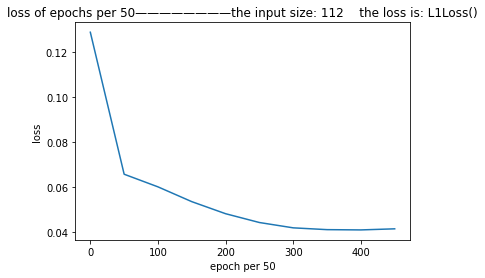

输入步长为112的训练集/验证集上的sMAPE指标：22.479237173322435


In [20]:
'''输入步长112_MAE_SGD'''
model_112_mae_sgd = NeuralNetwork(112).to(device)
loss_MAE = nn.L1Loss()#定义损失函数MSE
optimizer_112 = torch.optim.SGD(model_112_mae_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(train_input_112.to(torch.float32), train_output_112.to(torch.float32), 112, model_112_mae_sgd, loss_MAE, optimizer_112, 500)

acc_112 = cal_sMAPE_train(train_output_112[:,[train_output_112.shape[1]-1],:].squeeze(), prediction[:,[train_output_112.shape[1]-1],:].squeeze(), train_max, train_min, 112)

the loss of epoch 0 is: 0.004070738796144724
the loss of epoch 50 is: 0.001507694716565311
the loss of epoch 100 is: 0.0014827892882749438
the loss of epoch 150 is: 0.001504526357166469
the loss of epoch 200 is: 0.0014398217899724841
the loss of epoch 250 is: 0.0015402069548144937


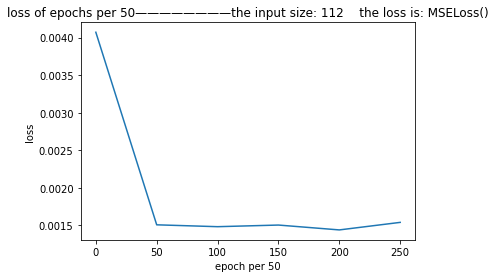

输入步长为112的训练集/验证集上的sMAPE指标：29.946752347622585


In [21]:
'''输入步长112_MSE_ADAM'''
model_112_mse_adam = NeuralNetwork(112).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_112 = torch.optim.Adam(model_112_mse_adam.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(train_input_112.to(torch.float32), train_output_112.to(torch.float32), 112, model_112_mse_adam, loss_MSE, optimizer_112, 300)

acc_112 = cal_sMAPE_train(train_output_112[:,[train_output_112.shape[1]-1],:].squeeze(), prediction[:,[train_output_112.shape[1]-1],:].squeeze(), train_max, train_min, 112)

the loss of epoch 0 is: 0.021549642086029053
the loss of epoch 50 is: 0.012720318511128426
the loss of epoch 100 is: 0.007498071063309908
the loss of epoch 150 is: 0.004576957318931818
the loss of epoch 200 is: 0.0033489104826003313
the loss of epoch 250 is: 0.003142022993415594
the loss of epoch 300 is: 0.0033642579801380634
the loss of epoch 350 is: 0.0036743038799613714
the loss of epoch 400 is: 0.003939430695027113
the loss of epoch 450 is: 0.004126734100282192


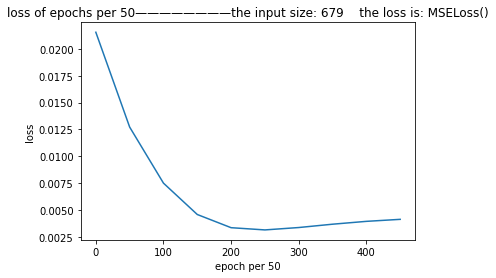

输入步长为679的训练集/验证集上的sMAPE指标：25.396278391854942


In [154]:
'''输入步长679，利用训练集训练模型，并计算训练集自身的sMAPE值'''
model_679_mse_sgd = NeuralNetwork(679).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_679 = torch.optim.SGD(model_679_mse_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(train_input_679.to(torch.float32), train_output_679.to(torch.float32), 679, model_679_mse_sgd, loss_MSE, optimizer_679, 500)

acc_679 = cal_sMAPE_train(train_output_679[:,[train_output_679.shape[1]-1],:].squeeze(), prediction[:,[train_output_679.shape[1]-1],:].squeeze(), train_max, train_min, 679)

the loss of epoch 0 is: 0.12030184268951416
the loss of epoch 50 is: 0.06456144899129868
the loss of epoch 100 is: 0.046186089515686035
the loss of epoch 150 is: 0.04358677938580513
the loss of epoch 200 is: 0.04083686321973801
the loss of epoch 250 is: 0.03800925984978676
the loss of epoch 300 is: 0.03529734164476395
the loss of epoch 350 is: 0.03283338621258736
the loss of epoch 400 is: 0.030510619282722473
the loss of epoch 450 is: 0.028332756832242012


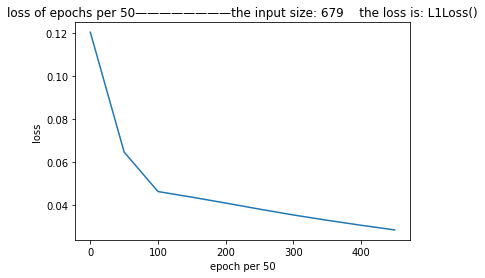

输入步长为679的训练集/验证集上的sMAPE指标：21.46000327410959


In [22]:
'''输入步长679_MAE_SGD'''
model_679_mae_sgd = NeuralNetwork(679).to(device)
loss_MAE = nn.L1Loss()#定义损失函数MSE
optimizer_679 = torch.optim.SGD(model_679_mae_sgd.parameters(), lr=1e-3)  #记住这里也要改模型的名字model_56.parameters()

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(train_input_679.to(torch.float32), train_output_679.to(torch.float32), 679, model_679_mae_sgd, loss_MAE, optimizer_679, 500)

acc_679 = cal_sMAPE_train(train_output_679[:,[train_output_679.shape[1]-1],:].squeeze(), prediction[:,[train_output_679.shape[1]-1],:].squeeze(), train_max, train_min, 679)

the loss of epoch 0 is: 0.0043336255475878716
the loss of epoch 50 is: 0.0004490639839787036
the loss of epoch 100 is: 0.0006184006342664361
the loss of epoch 150 is: 0.0003199840721208602
the loss of epoch 200 is: 0.0004387007502373308
the loss of epoch 250 is: 0.00033982566674239933


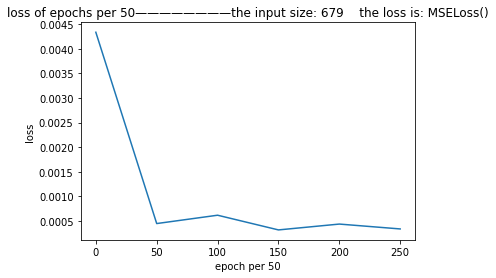

输入步长为679的训练集/验证集上的sMAPE指标：15.504088380312089


In [23]:
'''输入步长679_MSE_ADAM'''
model_679_mse_adam = NeuralNetwork(679).to(device)
loss_MSE = nn.MSELoss()#定义损失函数MSE
optimizer_679 = torch.optim.Adam(model_679_mse_adam.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = train(train_input_679.to(torch.float32), train_output_679.to(torch.float32), 679, model_679_mse_adam, loss_MSE, optimizer_679, 300)

acc_679 = cal_sMAPE_train(train_output_679[:,[train_output_679.shape[1]-1],:].squeeze(), prediction[:,[train_output_679.shape[1]-1],:].squeeze(), train_max, train_min, 679)

以下为利用训练集训练模型，计算验证集dev的sMAPE。
经过实验，我发现上面的计算方法确实会让sMAPE虚高，因此3种输入步长对验证集和训练集的sMAPE的计算，让最后一个输入序列输入模型中得到预测值，然后和与之对应的输出对计算sMAPE。我对比了三种输入长度的两种不同方法，SGD和ADAM；MSE和MAE

In [182]:
'''输入步长56——SGD——MSE'''
#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = model_56_mse_sgd(dev_input_56.to(torch.float32).to(device))

acc_56 = cal_sMAPE_train(dev_output_56[:,[dev_output_56.shape[1]-1],:].squeeze(), prediction[:,[dev_output_56.shape[1]-1],:].squeeze(), dev_max, dev_min, 56)

输入步长为56的训练集/验证集上的sMAPE指标：28.640501576859773


In [24]:
'''输入步长56——SGD——MAE'''
#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = model_56_mae_sgd(dev_input_56.to(torch.float32).to(device))

acc_56 = cal_sMAPE_train(dev_output_56[:,[dev_output_56.shape[1]-1],:].squeeze(), prediction[:,[dev_output_56.shape[1]-1],:].squeeze(), dev_max, dev_min, 56)

输入步长为56的训练集/验证集上的sMAPE指标：26.978578151944788


In [25]:
'''输入步长56——ADAM——MSE'''
#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = model_56_mse_adam(dev_input_56.to(torch.float32).to(device))

acc_56 = cal_sMAPE_train(dev_output_56[:,[dev_output_56.shape[1]-1],:].squeeze(), prediction[:,[dev_output_56.shape[1]-1],:].squeeze(), dev_max, dev_min, 56)

输入步长为56的训练集/验证集上的sMAPE指标：53.50699849264944


In [184]:
'''输入步长112——SGD——MSE'''

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = model_112_mse_sgd(dev_input_112.to(torch.float32).to(device))

acc_112 = cal_sMAPE_train(dev_output_112[:,[dev_output_112.shape[1]-1],:].squeeze(), prediction[:,[dev_output_112.shape[1]-1],:].squeeze(), dev_max, dev_min, 112)

输入步长为112的训练集/验证集上的sMAPE指标：28.547955449726253


In [26]:
'''输入步长112——SGD——MAE'''

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = model_112_mae_sgd(dev_input_112.to(torch.float32).to(device))

acc_112 = cal_sMAPE_train(dev_output_112[:,[dev_output_112.shape[1]-1],:].squeeze(), prediction[:,[dev_output_112.shape[1]-1],:].squeeze(), dev_max, dev_min, 112)

输入步长为112的训练集/验证集上的sMAPE指标：24.65922524268969


In [27]:
'''输入步长112——ADAM——MSE'''

#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = model_112_mse_adam(dev_input_112.to(torch.float32).to(device))

acc_112 = cal_sMAPE_train(dev_output_112[:,[dev_output_112.shape[1]-1],:].squeeze(), prediction[:,[dev_output_112.shape[1]-1],:].squeeze(), dev_max, dev_min, 112)

输入步长为112的训练集/验证集上的sMAPE指标：31.11703909404807


In [185]:
'''输入步长679——SGD——MSE'''
#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = model_679_mse_sgd(dev_input_679.to(torch.float32).to(device))#利用dev的输入预测

acc_679 = cal_sMAPE_train(dev_output_679[:,[dev_output_679.shape[1]-1],:].squeeze(), prediction[:,[dev_output_679.shape[1]-1],:].squeeze(), dev_max, dev_min, 679)

输入步长为679的训练集/验证集上的sMAPE指标：27.656739887773803


In [29]:
'''输入步长679——SGD——MAE'''
#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = model_679_mae_sgd(dev_input_679.to(torch.float32).to(device))#利用dev的输入预测

acc_679 = cal_sMAPE_train(dev_output_679[:,[dev_output_679.shape[1]-1],:].squeeze(), prediction[:,[dev_output_679.shape[1]-1],:].squeeze(), dev_max, dev_min, 679)

输入步长为679的训练集/验证集上的sMAPE指标：24.629717296877278


In [31]:
'''输入步长679——ADAM——MSE'''
#需要注意.to(torch.float32)用来将数据转化为一致的类型，否则报错
prediction = model_679_mse_adam(dev_input_679.to(torch.float32).to(device))#利用dev的输入预测

acc_679 = cal_sMAPE_train(dev_output_679[:,[dev_output_679.shape[1]-1],:].squeeze(), prediction[:,[dev_output_679.shape[1]-1],:].squeeze(), dev_max, dev_min, 679)

输入步长为679的训练集/验证集上的sMAPE指标：22.631216668130538
